# Choose a Model
In this notebook, I am going to explore different models in R. Outputs in R are more interpretable than in Python. 

**Contents:**
1. Decision tree 
2. Logistic regression 
3. Random Forest, SVM, kNN, Naive Bayes... (maybe)

In [1]:
library(dplyr)          # Data frame manipulation
library(rpart)          # Decision trees
library(rpart.plot)
library(rattle)         # Fancy tree plot
library(RColorBrewer)   # Color selection


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Rattle: A free graphical interface for data science with R.
Version 5.2.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


In [2]:
col_names <- c('age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
               'race','sex','capital-gain','capital-loss','hours-per-week','native-country','class')

data <- read.csv('../data/adult.data', col.names = col_names, strip.white = TRUE)
data[data == '?'] <- NA

data %>% head()

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,class
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


In [3]:
## gather variables
train <- data; train$fnlwgt <- NULL; train$education.num <- NULL

# workclass
train$workclass <- as.character(train$workclass)
train$workclass[train$workclass %in% c('Never-worked','Without-pay')] <- 'Unemployed'
train$workclass <- factor(train$workclass)

# education
train$education <- factor(train$education, ordered = TRUE, levels = c('Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college','Assoc-acdm','Assoc-voc','Bachelors','Masters','Prof-school','Doctorate'))
train$educ <- train$education < '5th-6th';                 train$educ <- train$educ + (train$education < '10th')
train$educ <- train$educ + (train$education < 'HS-grad');  train$educ <- train$educ + (train$education < 'Assoc-acdm')
train$educ <- train$educ + (train$education < 'Bachelors');train$educ <- train$educ + (train$education < 'Masters')
train$educ <- factor(train$educ + (train$education < 'Prof-school'), levels = c(7,6,5,4,3,2,1,0))
levels(train$educ) <- c('before-4th','5th-9th', '10th-12th','HS-grad','Assoc','Bachelors','Masters','Doc-prof'); train$education <- NULL

# marital status
train$marital.status <- as.character(train$marital.status)
train$marital.status[train$marital.status %in% c('Married-AF-spouse','Married-civ-spouse')] <- 'Married'
train$marital.status[train$marital.status %in% c('Married-spouse-absent','Widowed')] <- 'Widowed-Spouse-absent'
train$marital.status <- factor(train$marital.status)

# occupation
train$occupation <- as.character(train$occupation)
train$occupation[train$occupation %in% c('Priv-house-serv','Other-service')] <- 'Other-service'
train$occupation[train$occupation %in% c('Armed-Forces','Farming-fishing','Machine-op-inspct')] <- 'Other-occupation'
train$occupation[train$occupation %in% c('Sales','Tech-support')] <- 'Office-service'
train$occupation <- factor(train$occupation)

# relationship
train$relationship <- as.character(train$relationship)
train$relationship[train$relationship %in% c('Other-relative','Own-child')] <- 'With-relative'
train$relationship[train$relationship %in% c('Not-in-family','Unmarried')] <- 'Not-in-family'
train$relationship[train$relationship %in% c('Husband','Wife')] <- 'Married'
train$relationship <- factor(train$relationship)

# native country
train$native.country <- as.character(train$native.country)
train$native.country[train$native.country %in% c('United-States','Canada','Outlying-US(Guam-USVI-etc)')] <- 'north-america'
train$native.country[train$native.country %in% c('Cuba','Puerto-Rico','Dominican-Republic','Haiti','Jamaica')] <- 'carribean'
train$native.country[train$native.country %in% c('Honduras','Guatemala','Nicaragua','El-Salvador','Trinadad&Tobago','Peru','Columbia','Ecuador')] <- 'south-america'
train$native.country[train$native.country %in% c('England','Holand-Netherlands','Ireland','Hungary','Greece','Scotland','Germany','Yugoslavia','Poland','Portugal','France','Italy')] <- 'europe'
train$native.country[train$native.country %in% c('China','Hong','Japan','Philippines','India','Vietnam','Cambodia','Thailand','South','Iran','Laos','Taiwan')] <- 'asia'
train$native.country <- factor(train$native.country)

# Race
train$race <- factor(train$race, levels = c('White','Asian-Pac-Islander','Black','Amer-Indian-Eskimo','Other'))

The categorical variables have too many categories. I've fitted a very simple decision tree of each categorical variable regarding the earning class to get some insights on how I can group the categories while keeping the effect on the class.

In [4]:
## Fit a logistic regression on the full data
glm <- glm(class ~ ., data = train, family = binomial(link='logit'))
summary(glm)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = class ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.1184  -0.5255  -0.2041  -0.0242   4.0252  

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -6.863e+00  6.146e-01 -11.166  < 2e-16 ***
age                                  2.252e-02  1.666e-03  13.518  < 2e-16 ***
workclassLocal-gov                  -7.131e-01  1.111e-01  -6.418 1.38e-10 ***
workclassPrivate                    -5.120e-01  9.204e-02  -5.563 2.65e-08 ***
workclassSelf-emp-inc               -3.722e-01  1.219e-01  -3.053 0.002267 ** 
workclassSelf-emp-not-inc           -1.086e+00  1.074e-01 -10.103  < 2e-16 ***
workclassState-gov                  -8.457e-01  1.235e-01  -6.849 7.43e-12 ***
workclassUnemployed                 -1.228e+01  1.219e+02  -0.101 0.919765    
marital.statusMarried                2.284e+00  2.542e-01   8.985  < 2e-16 ***


**Analysis of the Logistic Regression:**  
The logistic regression looks at the effect of each variable on the earning class. The effect is measured by a coefficient and a p-value for each numeric variable, and each category of categorical variables. If the coefficient is positive, it means that people in this category are more likely to earn more. The effect is said significant when the p-value is low.  

With the above summary, we can analyse the effect of each variable on the earning class.

*Age* has a significant, positive effect on the class (p-value < 2e-16). It means that between two people with the same profile, but different age, the older is more likely to earn >50k than the younger.

*Workclass* effect is measured compared to the reference group "Federal government". All the other categories have a negative effect on the earning class, meaning that Federal-government is the most likely to earn more. The least likely to earn >50k is the Unemployed class (never-worked and without-pay) with a coefficient of -10. All the coefficients are significant, except the "Unemployed" class since its size is small.

*Marital Status* effect is measured by reference to "Divorced". "Never-married" are significantly the least likely to earn >50k, with a coefficient of -0.4. "Married" (civilian and AF) are significantly the most likely to earn >50k with a coefficient of 2.3. We notice that "Separated" and "Widowed-Spouse-absent" have small effect, not significantly different from divorced.

*Occupation* effect is measured by reference to "adm-clerical". "Other-service" are significantly the least likely to earn >50k, with a coefficient of -0.9. "Executive-managerial" are significantly the most likely to earn >50k with a coefficient of 0.8. 

*Relationship* effect is measured by reference to "Married" (Husband and Wife). "With-relative" are significantly the least likely to earn >50k, with a coefficient of -0.9. We notice that "Not-in-family" are not significantly different from Married.

*Race* effect is measured by reference to "White". "Amer-Indian-Eskimo" are significantly the least likely to earn >50k, with a coefficient of -0.6. We notice that both "Asian-Pacific-Islander" and "Black" are not significantly different from White.

*Sex* has a significant effect on the class. It means that between two people with the same profile, the man is more likely to earn >50k than the woman, with a coefficient of 0.16.

*Capital Gain* has a significant effect on the class. It means that between two people with the same profile, the person that gained more capital is more likely to earn >50k than the person with less capital gain.

*Capital Loss* has a significant effect on the class. It means that between two people with the same profile, the person that lost more capital is more likely to earn >50k than the person with less capital loss. It might sound weird, but it could be that if you have capital to loose from the start, then you are earning more.

*Hours per week* has a significant effect on the class. It means that between two people with the same profile, the person working more is more likely to earn >50k than the person working less.

*Native Country* effect is measured by reference to "Asia". "Europe" is significantly the most likely to earn >50k, with a coefficient of 0.5. "South-America" is the least likely to earn >50k with a coefficient of -0.5. We notice that "Mexico" and "Carribean" have smaller effect, not significantly different from "Asia".

*Education* effect is measured by reference to "before-4th", people that did go further than 4th grade. "before-4th" are the least likely to earn >50k. "Doctorate-Prof-school" are significantly more likely to earn >50k with a coefficient of 3.6. We notice that the coefficients of two consecutive categories are quite close, meaning that the effect is not significantly different between the two. However, between the lowest and the highest categories, the effect is more than significantly different.

This model, with aggregated categories, has a slightly higher AIC than the model with the original categories, but the interpretation is highly easier.

All the variables have an overall significant effect on the prediction of the earning class: removing one of them from the model increases the AIC. The variables with the most overall effect on the class detection are "capital-gain", "occupation" and "education". On the other hand, "race" and "sex" have a significant effect on the class detection, but way smaller than for the other variables.

----
**Decision Tree:**  
The regression is great to get the effect of each variable on the class detection. With a decision tree, we can identify criteria to split the data into groups labelled "<=50k" or ">50k". 

marital.status   relationship            age           educ   capital.gain 
    2439.96661     2417.73852     1300.98999     1242.48882     1221.54069 
    occupation            sex hours.per.week   capital.loss      workclass 
     904.20629      839.34179      765.38083      417.01134      240.38033 
          race native.country 
      82.16452       65.29880

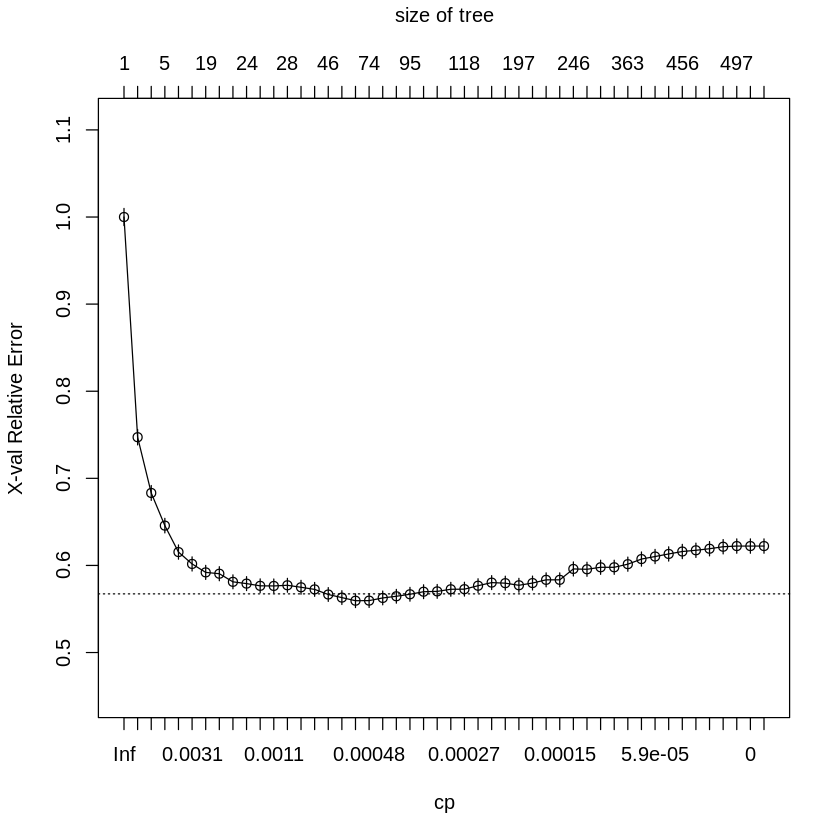

In [5]:
## Fit the decision tree on the full data
fit <- rpart(class ~ ., data = train, cp = -1)

fit$variable.importance
plotcp(fit)

While building the decision tree, the algorithm gives each variable an importance according to how much it helps splitthe data into the classes. For the tree, the most important variables are relationship and marital status. Race and native country are the least important. 

As the tree grows deeper, and becomes more complex, the error rate decreases. The minimum error we can acheive with one simple tree on this data is 58%, and it is reach for a complexity of 0.001. Going further for a more complex tree is useless. 

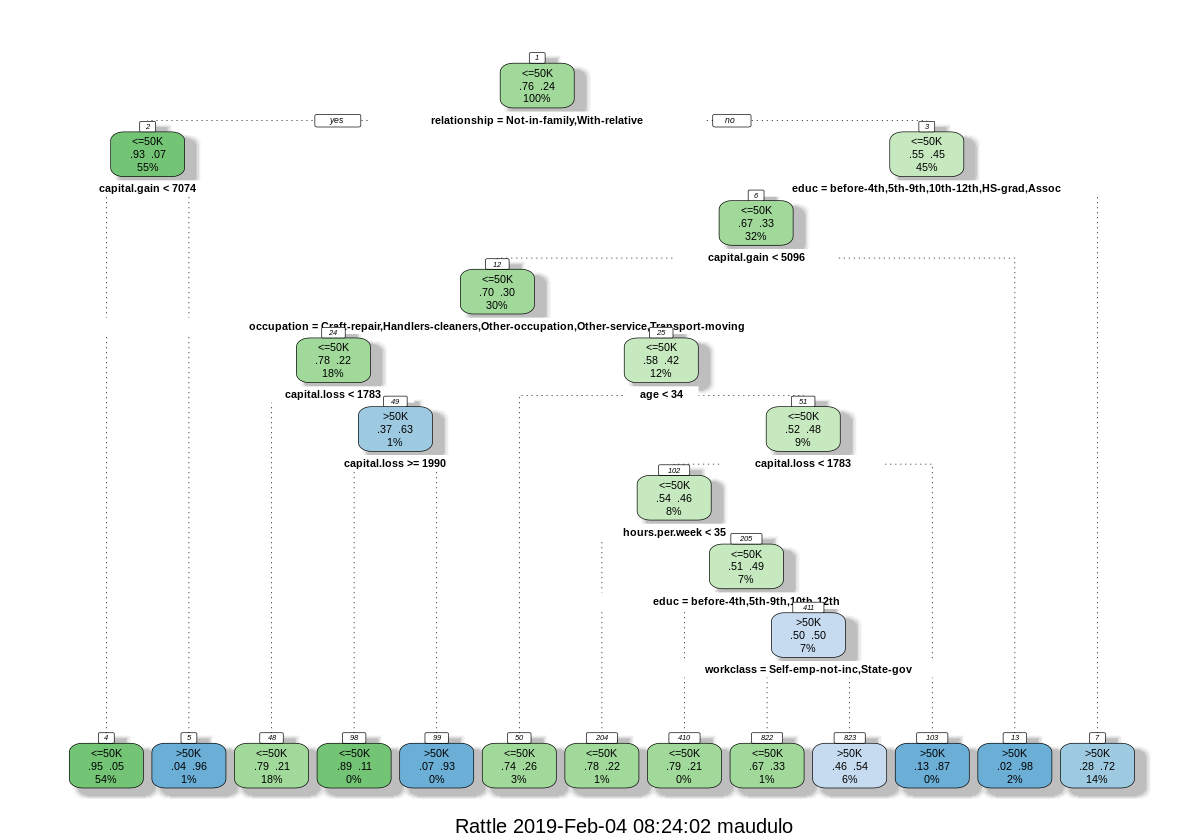

In [6]:
## Print a subset of the tree
fit <- prune(fit, cp=.005)

options(repr.plot.width = 10, repr.plot.height = 7, warn = FALSE)
fancyRpartPlot(fit)

I decided to cut the tree at a complexity of 0.0.006 (error rate of 60%) so we can read the graph easily. The dark green nodes are mainly people earning less than 50k, and the dark blue ones are people earning more than 50k.

The first split is between people in a Married relation ship (Wife and Husband) and the others. 
- Left: 55% of the respondents; among them, 93% earning <=50k, and 7% earning >50k
- Right: 45% of the respondents; among them, 55% earning <=50k, and 45% earning >50k.

The second and final split on the left tree is "Capital Gain < 7,074".   
The second split on the right tree is about education, with University Graduate students against the others.

In the end, the two most useful groups are:
- **1st Leaf** - People not in a married relationship and with a capital gain lower than 7k: 
    - they represent 54% of all respondents,
    - among them, 95% are earning less than 50k a year.  
**=>** It's a strong indicator of people that should not be detected by the model as potential donors.
- **Last Leaf** - People in a married relationship and who graduated from university (Bachelors, Masters, Doctorate or Prof-school):
    - they represent 14% of all respondents,
    - among them, 72% are earning more than 50k a year.  
**=>** It's a strong indicator of people that could be detected by the model as potential donors.
